<a href="https://colab.research.google.com/github/axandrei1234/Handwritten-Text-Recognition/blob/main/HandwrittenRecog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from google.colab import drive
from google.colab import files
import shutil
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from concurrent.futures import ProcessPoolExecutor
import time

In [ ]:
def extractAndCenterROI(binaryImage, padding=10, maxSize=(32, 32)):
    contours, _ = cv2.findContours(binaryImage, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        print("No contours found.")
        return None

    maxContour = max(contours, key=cv2.contourArea)

    x, y, w, h = cv2.boundingRect(maxContour)

    roi = binaryImage[y:y + h, x:x + w]
    roiWithPadding = np.zeros((h + 2 * padding, w + 2 * padding), dtype=np.uint8)
    roiWithPadding[padding:padding + h, padding:padding + w] = roi

    roiResized = cv2.resize(roiWithPadding, maxSize, interpolation=cv2.INTER_AREA)

    return roiResized


def whiteMask(image, squareSize):
    mask = np.zeros_like(image)
    mask[:squareSize//2, :] = 255  # Top region
    mask[-squareSize//2:, :] = 255  # Bottom region
    mask[:, :squareSize//2] = 255  # Left region
    mask[:, -squareSize//2:] = 255  # Right region
    resultImage = np.where(mask == 255, 255, image)
    return resultImage

def increaseBrightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

def adjustMeanValue(image, target_mean):
    currentMean = np.mean(image)
    adjustmentFactor = target_mean / currentMean
    adjustedImage = np.clip(image * adjustmentFactor, 0, 255).astype(np.uint8)
    return adjustedImage

def adjustThickness(binaryImage, desiredThickness):
    desiredThickness = max(0, desiredThickness)

    kernelDilate = np.ones((desiredThickness, desiredThickness), np.uint8)
    dilatedImage = cv2.dilate(binaryImage, kernelDilate, iterations=1)

    kernelErode = np.ones((desiredThickness, desiredThickness), np.uint8)
    erodedImage = cv2.erode(dilatedImage, kernelErode, iterations=1)

    return erodedImage

In [ ]:
def processImages(input_dir, output_dir, desired_thickness):
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    count = 1

    for filename in os.listdir(input_dir):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            print(f"Processing image: {filename}")

            input_path = os.path.join(input_dir, filename)
            initialImage = cv2.resize(cv2.imread(input_path), (32,32), interpolation = cv2.INTER_CUBIC)
            image = adjustMeanValue(increaseBrightness(cv2.imread(input_path), 20), 150)
            imageGray = cv2.cvtColor(cv2.imread(input_path), cv2.COLOR_BGR2GRAY)
            imageResized = cv2.resize(imageGray, (128, 128), interpolation=cv2.INTER_AREA)
            thresh = 127
            imageBinary = cv2.threshold(imageResized, thresh, 255, cv2.THRESH_BINARY)[1]
            maskedImage = whiteMask(imageBinary, 64)
            cv2.imwrite('temp.png', maskedImage)
            imageBinaryResizedRead = cv2.imread('temp.png', cv2.IMREAD_GRAYSCALE)  # Read the saved image in grayscale

            height, width = imageBinaryResizedRead.shape

            for y in range(height):
                for x in range(width):
                    if imageBinaryResizedRead[y, x] == 255:
                        imageBinaryResizedRead[y, x] = 0
                    else:
                        imageBinaryResizedRead[y, x] = 255
            os.remove('temp.png')

            newImage = cv2.GaussianBlur(imageBinaryResizedRead, (3, 3), 0.3)
            roiImage = extractAndCenterROI(newImage, padding=2)

            adjustedImage = adjustThickness(roiImage, desired_thickness)

            finalImage = cv2.resize(adjustedImage, (32, 32), interpolation=cv2.INTER_CUBIC)

            output_path = os.path.join(output_dir, f"testImage{count}.png")
            cv2.imwrite(output_path, finalImage)
            print(f"Processed image saved to: {output_path}")

            count += 1

In [ ]:
if __name__ == "__main__":
    inputDirectory = 'inputPictures'
    outputDirectory = 'processedImages'

    desiredThickness = 0

    processImages(inputDirectory, outputDirectory, desiredThickness)

    shutil.make_archive('/content/processedImages', 'zip', '/content/processedImages')


In [ ]:
%rm -rf inputPictures
%rm -rf processedImages
%rm -rf dataset
%rm -rf __MACOSX
%rm -rf processedImages.zip

In [ ]:
!unzip dataset.zip

In [ ]:
directory = 'dataset/'
df = pd.read_csv(directory + 'trainCVTest.csv')

train_df, temp_df = train_test_split(df, test_size=0.3, random_state=31)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=31)

# Extract file paths and labels for each set
train_file_paths = train_df['file_name'].values
train_labels = train_df['label'].values

val_file_paths = val_df['file_name'].values
val_labels = val_df['label'].values

test_file_paths = test_df['file_name'].values
test_labels = test_df['label'].values

# Create a mapping from string labels to integer labels
label_mapping = {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4,
                 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9,
                 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14,
                 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19,
                 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24,
                 'z': 25}

# Convert string labels to integer labels
train_labels = [label_mapping[label] for label in train_labels]
val_labels = [label_mapping[label] for label in val_labels]
test_labels = [label_mapping[label] for label in test_labels]

# Create separate datasets for train, validation, and test
ds_train = tf.data.Dataset.from_tensor_slices((train_file_paths, train_labels))
ds_val = tf.data.Dataset.from_tensor_slices((val_file_paths, val_labels))
ds_test = tf.data.Dataset.from_tensor_slices((test_file_paths, test_labels))

def readImage(image_file, label):
    image = tf.io.read_file(directory + image_file)
    image = tf.image.decode_image(image, channels=1, dtype=tf.float32)
    return image, label

batchSize = 32
ds_train = ds_train.map(readImage).batch(batchSize)
ds_val = ds_val.map(readImage).batch(batchSize)
ds_test = ds_test.map(readImage).batch(batchSize)



model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu',input_shape=(32, 32, 1),  padding='same', name="Conv1"))
model.add(layers.MaxPooling2D((2, 2), name='MaxPooling1'))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='Conv2'))
model.add(layers.MaxPooling2D((2, 2), name='MaxPooling2'))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', name="Conv3"))
model.add(layers.MaxPooling2D((2, 2), name='MaxPooling3'))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', name="Conv4"))
model.add(layers.MaxPooling2D((2, 2), name='MaxPooling4'))
model.add(layers.Flatten(name='Flatten'))
model.add(layers.Dense(128, activation='relu', name='Dense1'))
model.add(layers.Dropout(0.55))
model.add(layers.Dense(64, activation='relu', name='Dense2'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(26, activation='softmax', name='FinalLayer'))

# model = models.Sequential()
# model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(32, 32, 1), padding='same', name="Conv1"))
# model.add(layers.MaxPooling2D((2, 2), name='MaxPooling1'))
# model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='Conv2'))
# model.add(layers.MaxPooling2D((2, 2), name='MaxPooling2'))
# model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', name="Conv3"))
# model.add(layers.MaxPooling2D((2, 2), name='MaxPooling3'))
# model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', name="Conv4"))
# model.add(layers.MaxPooling2D((2, 2), name='MaxPooling4'))
# model.add(layers.Flatten(name='Flatten'))
# model.add(layers.Dense(256, activation='relu', name='Dense1'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(128, activation='relu', name='Dense2'))
# model.add(layers.Dropout(0.3))
# model.add(layers.Dense(26, activation='softmax', name='FinalLayer'))
model.summary()

# Compile the model
model.compile(optimizer= tf.keras.optimizers.Adam(0.0013),
              loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

numEpochs = 15

plot_model(model, to_file='my_CNN_plot.png', show_shapes=True, show_layer_names=True)
history = model.fit(ds_train, epochs = numEpochs, validation_data=ds_val)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 32, 32, 64)        640       
                                                                 
 MaxPooling1 (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 Conv2 (Conv2D)              (None, 16, 16, 128)       73856     
                                                                 
 MaxPooling2 (MaxPooling2D)  (None, 8, 8, 128)         0         
                                                                 
 Conv3 (Conv2D)              (None, 8, 8, 64)          73792     
                                                                 
 MaxPooling3 (MaxPooling2D)  (None, 4, 4, 64)          0         
                                                                 
 Conv4 (Conv2D)              (None, 4, 4, 32)          1

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


114/114 [==============================] - 9s 19ms/step - loss: 2.7816 - accuracy: 0.1618 - val_loss: 1.1981 - val_accuracy: 0.6346
Epoch 2/15
114/114 [==============================] - 1s 9ms/step - loss: 1.0710 - accuracy: 0.6475 - val_loss: 0.2047 - val_accuracy: 0.9513
Epoch 3/15
114/114 [==============================] - 1s 8ms/step - loss: 0.5320 - accuracy: 0.8223 - val_loss: 0.0745 - val_accuracy: 0.9808
Epoch 4/15
114/114 [==============================] - 1s 9ms/step - loss: 0.3613 - accuracy: 0.8838 - val_loss: 0.0619 - val_accuracy: 0.9808
Epoch 5/15
114/114 [==============================] - 1s 8ms/step - loss: 0.2597 - accuracy: 0.9165 - val_loss: 0.0397 - val_accuracy: 0.9897
Epoch 6/15
114/114 [==============================] - 1s 8ms/step - loss: 0.2181 - accuracy: 0.9255 - val_loss: 0.0322 - val_accuracy: 0.9885
Epoch 7/15
114/114 [==============================] - 1s 11ms/step - loss: 0.1682 - accuracy: 0.9420 - val_loss: 0.0294 - val_accuracy: 0.9885
Epoch 8/15
114/

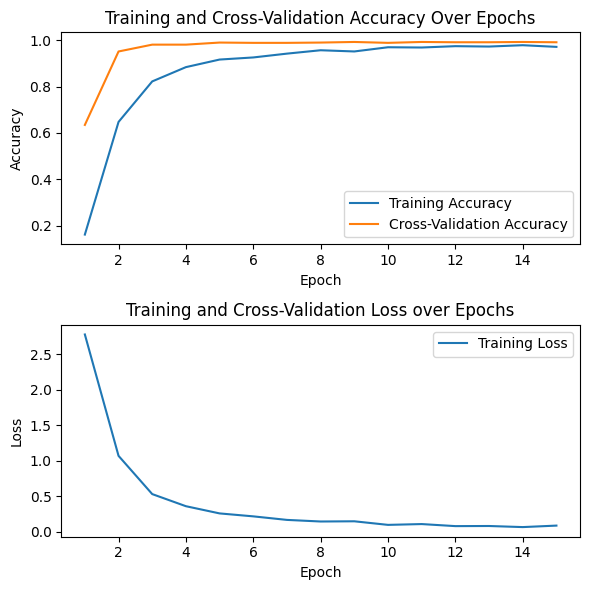

In [ ]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['loss']

epochs = range(1, numEpochs + 1)  # Replace num_epochs with the actual number of training epochs

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=False, figsize=(6, 6))

# Plotting the training and cross-validation accuracy
ax1.plot(epochs, training_accuracy, label='Training Accuracy')
ax1.plot(epochs, validation_accuracy, label='Cross-Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('Training and Cross-Validation Accuracy Over Epochs')
ax1.legend()

ax2.plot(epochs, training_loss, label='Training Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Training and Cross-Validation Loss over Epochs')
ax2.legend()

plt.tight_layout()

plt.show()

In [ ]:
predictions = model.predict(ds_test)

predicted_labels = np.argmax(predictions, axis=1)

true_labels = np.concatenate([label.numpy() for _, label in ds_test], axis=0)

reverse_label_mapping = {v: k for k, v in label_mapping.items()}
predicted_labels_str = [reverse_label_mapping[label] for label in predicted_labels]
true_labels_str = [reverse_label_mapping[label] for label in true_labels]


print("Predicting the test set")
for true_label, predicted_label in zip(true_labels_str, predicted_labels_str):
    print(f'True Label: {true_label}, Predicted Label: {predicted_label}')

accuracy = accuracy_score(true_labels_str, predicted_labels_str)

print(f'Accuracy: {accuracy * 100:.2f}%')

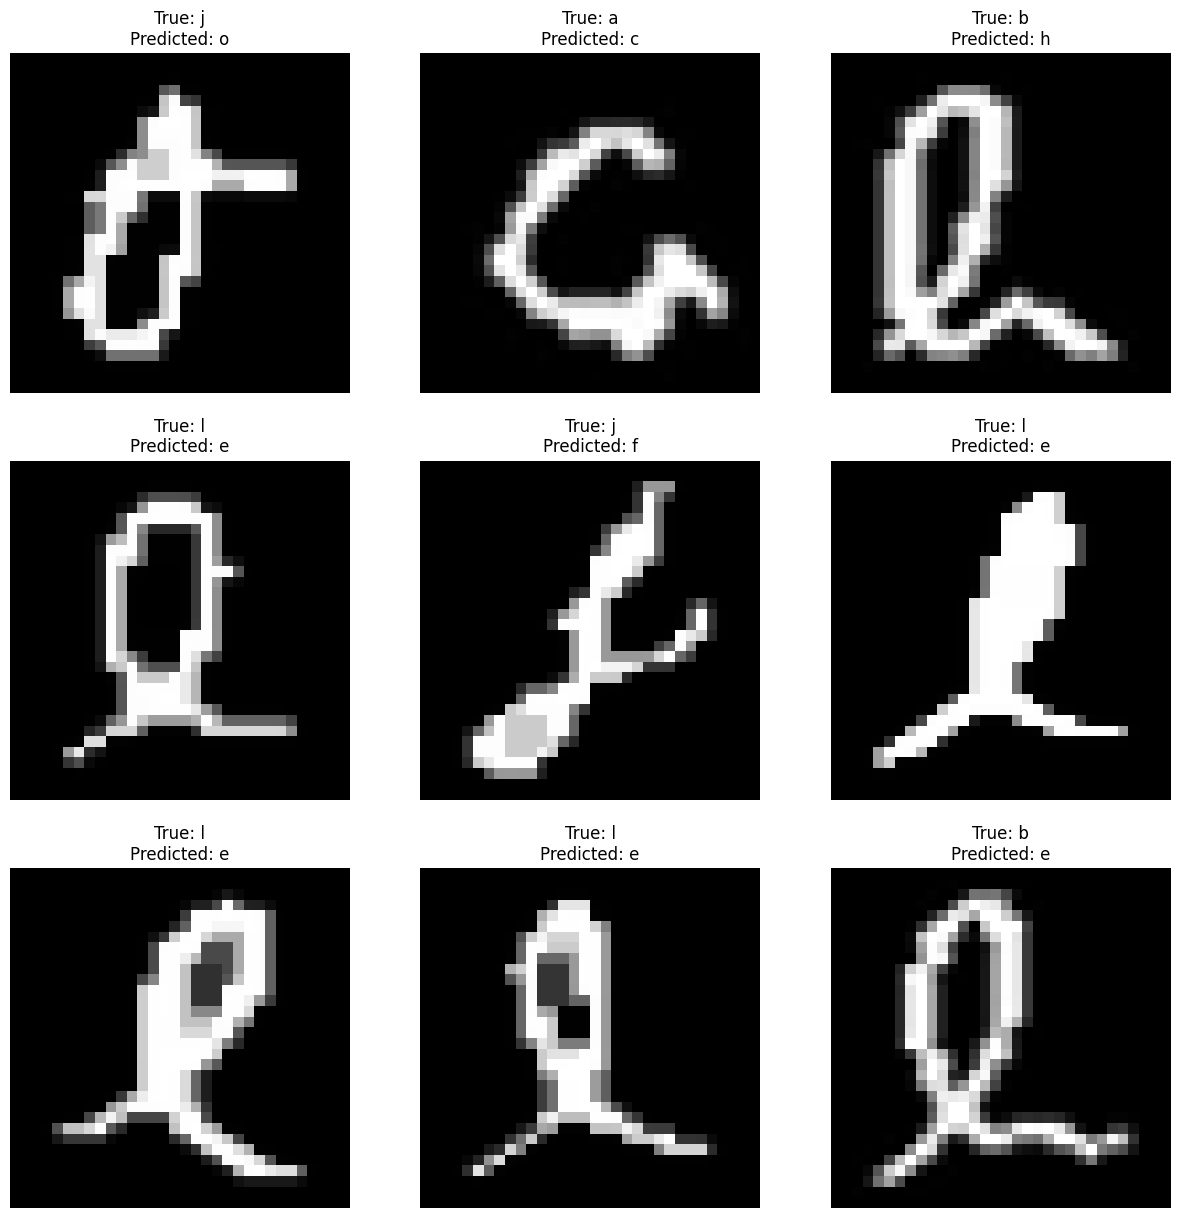

In [ ]:
misclassified_indices = np.where(predicted_labels != true_labels)[0]

misclassified_images = []
misclassified_true_labels = []
misclassified_predicted_labels = []

for i in misclassified_indices:
    # Get the ith image and label from the dataset
    image, true_label = list(ds_test.unbatch().as_numpy_iterator())[i]
    misclassified_images.append(image)
    misclassified_true_labels.append(true_labels_str[i])
    misclassified_predicted_labels.append(predicted_labels_str[i])

# Display misclassified images with true and predicted labels
num_misclassified = len(misclassified_images)
if num_misclassified > 0:
    # Set the number of images per row
    images_per_row = 3
    num_rows = int(np.ceil(num_misclassified / images_per_row))

    plt.figure(figsize=(15, 5 * num_rows))
    for i in range(num_misclassified):
        plt.subplot(num_rows, images_per_row, i + 1)
        plt.imshow(np.squeeze(misclassified_images[i]), cmap='gray')
        plt.title(f'True: {misclassified_true_labels[i]}\nPredicted: {misclassified_predicted_labels[i]}')
        plt.axis('off')

    plt.show()
else:
    print("No misclassified images to display.")


In [ ]:
!unzip testSetProcessed.zip

In [ ]:
#new prediction
directory = 'testSetProcessed/'
prediction_label= []
images = []

# Sort filenames using a custom sorting key
image_filenames = sorted([f for f in os.listdir(directory) if f.endswith(".png")], key=lambda x: int(x.split('testImage')[1].split('.png')[0]))

for imageFilename in image_filenames:
    img_path = os.path.join(directory, imageFilename)

    # Read and decode the image using TensorFlow functions
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=1, dtype=tf.float32)
    img_array = np.expand_dims(img, axis=0)
    images.append(img_array)

images = np.vstack(images)
predictions = model.predict(images)
predicted_labels = np.argmax(predictions, axis=1)
predicted_labels_str = [reverse_label_mapping[label] for label in predicted_labels]

for filename, prediction in zip(image_filenames, predicted_labels_str):
    print(f"File: {filename}, Prediction: {prediction}")



1/1 [==============================] - 0s 299ms/step
File: testImage1.png, Prediction: s
File: testImage2.png, Prediction: v
File: testImage3.png, Prediction: m
File: testImage4.png, Prediction: a
File: testImage5.png, Prediction: b
File: testImage6.png, Prediction: t
File: testImage7.png, Prediction: r
File: testImage8.png, Prediction: h
File: testImage9.png, Prediction: d
File: testImage10.png, Prediction: e
